In [1]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import widgets
from IPython.display import display
import plotly.graph_objs as go
from plotly.widgets import GraphWidget
import plotly.tools as tls

In [2]:
terror=pd.read_csv('globalterrorismdb_0617dist.csv',encoding='ISO-8859-1')

# renaming to give better names
terror.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_type','weaptype1_txt':'Weapon_type','motive':'Motive'},inplace=True)

# subset required columns
terror=terror[['Year','Month','Day','Country','Region','city','latitude','longitude','AttackType','Killed','Wounded','Group']]

# adding casualities 
terror['casualities']=terror['Killed']+terror['Wounded']

terror.head(3)

/Users/princegrover/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Group,casualities
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1.0,0.0,MANO-D,1.0
1,1970,0,0,Mexico,North America,Mexico city,19.432608,-99.133207,Hostage Taking (Kidnapping),0.0,0.0,23rd of September Communist League,0.0
2,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1.0,0.0,Unknown,1.0


In [3]:
terror.dropna(inplace=True)

In [4]:
terror.shape

(150159, 13)

In [5]:
terror.head()

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Group,casualities
0,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1.0,0.0,MANO-D,1.0
1,1970,0,0,Mexico,North America,Mexico city,19.432608,-99.133207,Hostage Taking (Kidnapping),0.0,0.0,23rd of September Communist League,0.0
2,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1.0,0.0,Unknown,1.0
5,1970,1,1,United States,North America,Cairo,37.005105,-89.176269,Armed Assault,0.0,0.0,Black Nationalists,0.0
6,1970,1,2,Uruguay,South America,Montevideo,-34.891151,-56.187214,Assassination,0.0,0.0,Tupamaros (Uruguay),0.0


### Total people killed in each country for each decade

In [43]:
terror['Decade'] = (terror['Year']//10)*10

In [44]:
terror.Decade[:2]

0    1970
1    1970
Name: Decade, dtype: int64

In [61]:
# first get top 20 countries in terms of number of killings

top20killings = list(pd.DataFrame(terror.groupby(['Country']).sum()
                  ['Killed'].sort_values(ascending=False))
     [:20].reset_index()['Country'])

In [63]:
terror_country_killings = pd.DataFrame(terror.groupby(['Country', 'Decade']).sum()['Killed'].reset_index())

In [68]:
terror_country_killings20 = terror_country_killings[terror_country_killings.Country.isin(top20killings)]

In [71]:
df_stack = terror_country_killings20.pivot(index='Country', columns = 'Decade', values = 'Killed')

In [72]:
df_stack.fillna(value=0, inplace=True)

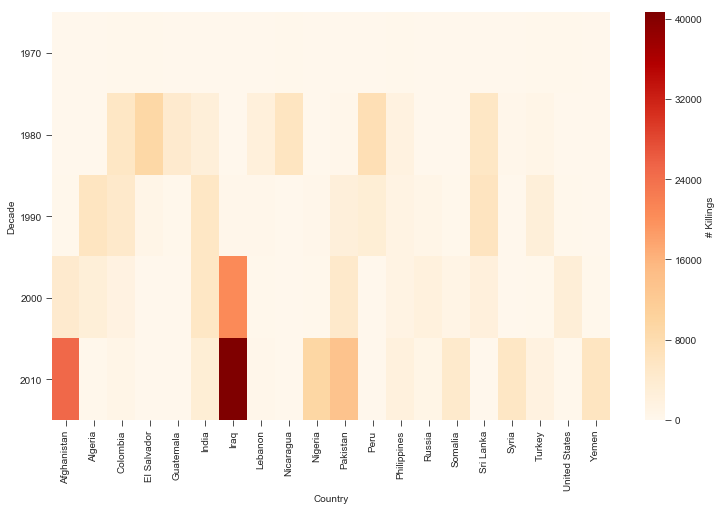

In [99]:
sns.set_style('ticks')

plt.figure(figsize=(12.5,7.5))

# plot heatmap
ax = sns.heatmap(df_stack.T,  cmap="OrRd", cbar_kws={'label': '# Killings'})

# turn the axis label
for item in ax.get_yticklabels():
    item.set_rotation(0)

for item in ax.get_xticklabels():
    item.set_rotation(90)

# save figure
plt.savefig('/Users/princegrover/Downloads/startbootstrap-creative-gh-pages_2/heatmap_ctr_dec.png')
plt.show()

### Distribution of casualities

Text(0.5,1,'Distribution of Casualities per attack ')

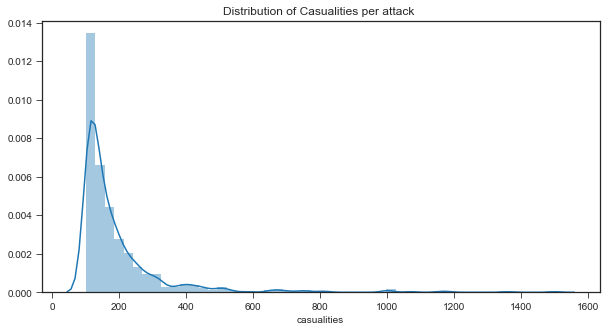

In [112]:
# plots a gaussian kernel density line also (smooth version of histogram)
sns.set_style('ticks')
plt.figure(figsize=(10, 5))
ax = sns.distplot(terror[(terror.casualities < 2000) & (terror.casualities > 100) ]['casualities'])
ax.set_title('Distribution of Casualities per attack ')

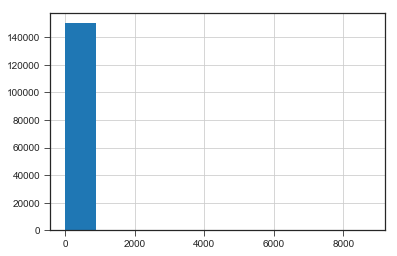

In [100]:
terror.casualities.hist()

### Activities of terrorist groups over the years

top 10 terrorist groups in each region in each year

### Decade in dropdown

In [259]:
grp_dec = terror.groupby(['Group', 'Decade']).count()['Year'].reset_index()

In [260]:
grp_dec.rename(columns={'Year': 'Attacks'}, inplace=True)

In [261]:
grp_dec[:2]

,Group,Decade,Attacks
0,1 May,1980,3
1,1 May,1990,6


In [306]:
grp_dec = grp_dec[grp_dec.Group != 'Unknown']

In [307]:
grp_dec.shape

(4140, 3)

In [333]:
data = []
for d in list(grp_dec.Decade.unique()):
    filtered_grp_dec = grp_dec[grp_dec.Decade == d]
    filtered_grp_dec = filtered_grp_dec.sort_values(by='Attacks', ascending=False)[:10]
    data.append(go.Bar(y = filtered_grp_dec.Group, 
                       x = filtered_grp_dec.Attacks, 
                       orientation = 'h'))

In [334]:
len(data)

5

In [335]:
for d in list(grp_dec.Decade.unique()):
    print(d)

1980
1990
2000
1970
2010


In [336]:
updatemenus = list([
    dict(active=-1,
         x=-0.3,
         buttons=list([  
             
            dict(
                label = '1980s',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False, False]}, 
                     {'title': '10 Most Active Terrorist Groups in 1980s'}]),
             
             dict(
                  label = '1990s',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False, False]},
                     {'title': '10 Most Active Terrorist Groups in 1990s'}]),

            dict(
                 label = '2000s',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False, False]},
                     {'title': '10 Most Active Terrorist Groups in 2000s'}]), 
             
                         dict(
                label = '1970s',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False, False]}, 
                     {'title': '10 Most Active Terrorist Groups in 1970s'}]),
             
             dict(
                  label = '2010s',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True, False]},
                     {'title': '10 Most Active Terrorist Groups in 2010s'}])
        ]),
    )
])

In [343]:
layout = dict(title='10 Most Active Terrorist Groups in Selected decade (Select from Dropdown)', showlegend=False,
              updatemenus=updatemenus,
              width=1100,
              height=500, 
              xaxis=dict(title='Number of Attacks'))

fig = dict(data=data, layout=layout)

# py.plot(fig)
plot(fig, filename='/Users/princegrover/Documents/msan/data_viz/group_dec.html' )

'file:///Users/princegrover/Documents/msan/data_viz/group_dec.html'

### Region in dropdown

In [313]:
grp_reg = terror.groupby(['Group', 'Region']).count()['Year'].reset_index()

In [314]:
grp_reg.rename(columns={'Year': 'Attacks'}, inplace=True)

In [315]:
grp_reg[:2]

,Group,Region,Attacks
0,1 May,Western Europe,9
1,14 K Triad,East Asia,4


In [316]:
grp_reg = grp_reg[grp_reg.Group != 'Unknown']

In [349]:
data = []
for d in list(grp_reg.Region.unique()):
    filtered_grp_reg = grp_reg[grp_reg.Region == d]
    filtered_grp_reg = filtered_grp_reg.sort_values(by='Attacks', ascending=False)[:10]
    data.append(go.Bar(y = filtered_grp_reg.Group,
                       x = filtered_grp_reg.Attacks,
                       orientation = 'h'))

In [350]:
len(data)

12

In [351]:
for d in list(grp_reg.Region.unique()):
    print(d)

Western Europe
East Asia
Middle East & North Africa
South America
Central America & Caribbean
Sub-Saharan Africa
North America
Eastern Europe
South Asia
Southeast Asia
Central Asia
Australasia & Oceania


In [352]:
updatemenus = list([
    dict(active=-1,
         x=-0.3,
         buttons=list([  
             
            dict(
                label = 'Western Europe',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False, False,
                                     False, False, False, False, False, False]}, 
                     {'title': '10 Most Active Terrorist Groups in Western Europe'}]),
             
             dict(
                  label = 'East Asia',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False, False, 
                                      False, False, False, False, False, False]},
                     {'title': '10 Most Active Terrorist Groups in East Asia'}]),

            dict(
                 label = 'Middle East & North Africa',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False, False,
                                      False, False, False, False, False, False]},
                     {'title': '10 Most Active Terrorist Groups in Middle East & North Africa'}]), 
             
                         dict(
                label = 'South America',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False, False, 
                                      False, False, False, False, False, False]}, 
                     {'title': '10 Most Active Terrorist Groups in South America'}]),
             
             dict(
                  label = 'Central America & Caribbean',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True, False, 
                                     False, False, False, False, False, False]},
                     {'title': '10 Most Active Terrorist Groups in Central America & Caribbean'}]),
                         dict(
                label = 'Sub-Saharan Africa',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, True,
                                      False, False, False, False, False, False]}, 
                     {'title': '10 Most Active Terrorist Groups in Sub-Saharan Africa'}]),
             
             dict(
                  label = 'North America',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False,
                                      True, False, False, False, False, False]},
                     {'title': '10 Most Active Terrorist Groups in North America'}]),

            dict(
                 label = 'Eastern Europe',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False,
                                      False, True, False, False, False, False ]},
                     {'title': '10 Most Active Terrorist Groups in Eastern Europe'}]), 
             
                         dict(
                label = 'South Asia',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, 
                                      False, False, True, False, False, False]}, 
                     {'title': '10 Most Active Terrorist Groups in South Asia'}]),
             
             dict(
                  label = 'Southeast Asia',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, 
                                      False, False, False, True, False, False ]},
                     {'title': '10 Most Active Terrorist Groups in Southeast Asia'}]), 
                                     dict(
                label = 'Central Asia',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, 
                                      False, False, False, False, True, False]}, 
                     {'title': '10 Most Active Terrorist Groups in Central Asia'}]),
             
             dict(
                  label = 'Australasia & Oceania',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, 
                                      False, False, False, False, False, True ]},
                     {'title': '10 Most Active Terrorist Groups in Australasia & Oceania'}])
        ]),
    )
])

In [354]:
layout = dict(title='10 Most Active Terrorist Groups in selected Region (Select from Dropdown)', showlegend=False,
              updatemenus=updatemenus, width=1100,
              height=500, 
              xaxis=dict(title='Number of Attacks'))

fig = dict(data=data, layout=layout)

# py.plot(fig)
plot(fig, filename='/Users/princegrover/Documents/msan/data_viz/group_reg.html' )

'file:///Users/princegrover/Documents/msan/data_viz/group_reg.html'

### End